In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#importing libraries

import numpy as np
import torch
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
char = '01234567ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [15]:
def img_cleaning(img):
  #converting the image to grayscale
  img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  #applied gaussian blur to reduce noise
  img_blur = cv2.GaussianBlur(img_gray, (0,0), sigmaX=4, sigmaY=4)

  #thresholding the image
  dst = cv2.adaptiveThreshold(img_blur, 255,
	              cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 6)

  return dst

In [16]:
#2#contour detection and extracting the images


def read(dst):

  #dilating the image
  dilated = cv2.dilate(dst.copy(), None, iterations=14)

  #detecting contours
  contours, hierarchy = cv2.findContours(dilated, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

  #removing small contours
  for c in contours:
    area = cv2.contourArea(c)

    # Small contours are ignored.
    if area < 5000:
        cv2.fillPoly(dilated, pts=[c], color=0)
        continue
  contours, hier = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  #Arranging contours in order
  m = []
  for i in range (len(contours)):
    c_0 = contours[i]

    # Get the 4 points of the bounding rectangle
    x, y, w, h = cv2.boundingRect(c_0)
    m.append([x,y,w,h])
  m = sorted(m, key = lambda x:x[0])
  captcha = []

  #list of extracted letters
  for i in m:
    image = dst[i[1]:i[1]+i[3] , i[0]:i[0]+i[2]]
    captcha.append(image)

  #reshaping these and appending them to a list
  IMG_HEIGHT = 28
  IMG_WIDTH = 28
  for i in range(len(captcha)):
    captcha[i]=cv2.resize(captcha[i], (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)

  return captcha

In [17]:
#Using a convolutional neural network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1,32,5)
    self.conv2 = nn.Conv2d(32,32,5)
    self.conv3 = nn.Conv2d(32,64,4)
    # self.bn1 = nn.BatchNorm2d(8)
    self.pool = nn.MaxPool2d(2,2)

    # self.conv3 = nn.Conv2d(8,16,5,padding = 2)
    # self.bn2 = nn.BatchNorm2d(16)
    # # self.conv3 = nn.Conv2d(6,12,5)
    # # self.bn3 = nn.BatchNorm2d(12)
    # # self.conv4 = nn.Conv2d(12,16,7)
    # # self.bn4 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,60)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv3(x)
    # # x = self.pool(self.bn4(F.relu(self.conv4(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return x

In [18]:
#device on which the model will be trained
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [19]:
PATH = '/content/drive/MyDrive/Handwritten-Captcha-Solver/model.h5' #path of model
load_model = torch.load(PATH)

In [20]:
def output(data):
  cap = ''
  for i in range(len(data)):
    t = torch.tensor(data[i],dtype = torch.float32)
    t = t.reshape(1,1,28,28)
    t = t.to(device)
    outputs = load_model(t)
    predicted = torch.max(outputs.data , 1)[1]
    cap += char[predicted.item()]
  return cap

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


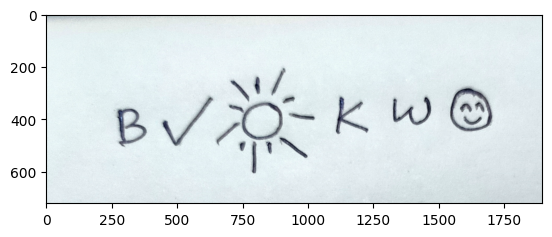

Correct Captcha: example.jpg, Predicted Captcha: BJ7KW6


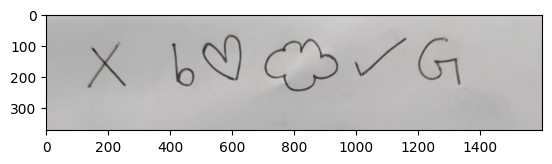

Correct Captcha: Xb421G.jpeg, Predicted Captcha: Xb22JG


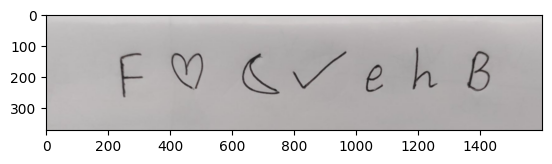

Correct Captcha: F431ehB.jpeg, Predicted Captcha: FCGJehB


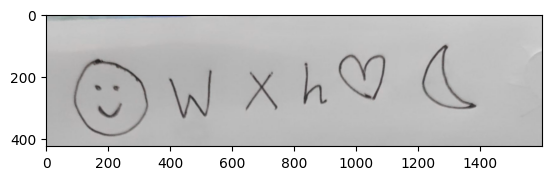

Correct Captcha: 6WXh43.jpeg, Predicted Captcha: e6WXhJC


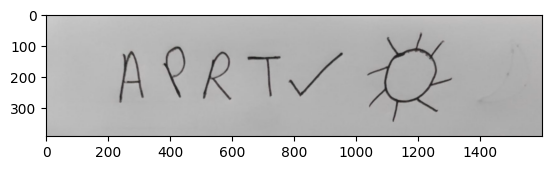

Correct Captcha: APRT17.jpeg, Predicted Captcha: Ae6TJ7


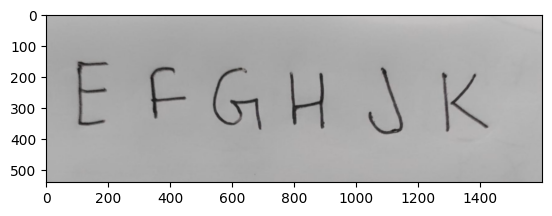

Correct Captcha: EFGHJK.jpeg, Predicted Captcha: eFGHJK


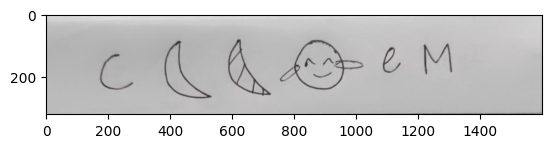

Correct Captcha: C335eM.jpeg, Predicted Captcha: C3TbBeMC


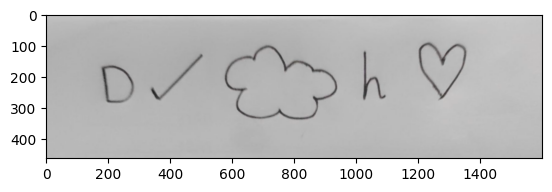

Correct Captcha: D12h4.jpeg, Predicted Captcha: WJJhJ


In [22]:
import os
# Folder path
folder_path = '/content/drive/MyDrive/Handwritten-Captcha-Solver/Test_Captchas'

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):  # Assuming you have image files
        # Construct the full path
        filepath = os.path.join(folder_path, filename)

        # Read the image
        img = cv2.imread(filepath)

        # Plot the original image

        plt.imshow(img, cmap='gray')
        plt.show()

        # Clean the image
        c_img = img_cleaning(img)

        # Read data from the cleaned image
        data = read(c_img)

        # Generate the captcha output
        captcha = output(data)

        # Print the captcha for each image
        print(f"Correct Captcha: {filename}, Predicted Captcha: {captcha}")